In [1]:
# Packages
import sys; sys.path.append('../')
import tqdm
import pandas as pd
import bnlearn as bn
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
import torchvision
import warnings
warnings.filterwarnings("ignore")

C:\Users\Dell\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Dell\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
test = pd.read_csv("SWaT_Dataset_Attack_v0.csv", index_col=0)
train = pd.read_csv("SWaT_Dataset_Normal_v1.csv", index_col=0)
train.head()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
22/12/2015 4:30:00 PM,0.0,124.3135,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
22/12/2015 4:30:01 PM,0.0,124.3920,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
22/12/2015 4:30:02 PM,0.0,124.4705,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
22/12/2015 4:30:03 PM,0.0,124.6668,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
22/12/2015 4:30:04 PM,0.0,124.5098,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal


In [5]:
train['attack'].replace('Normal', 0, inplace=True)
train['attack'].replace('Attack', 1, inplace=True) 
train['attack'].replace('A ttack', 1, inplace=True) 
test['attack'].replace('Normal', 0, inplace=True) 
test['attack'].replace('Attack', 1, inplace=True) 
test['attack'].replace('A ttack', 1, inplace=True)

In [6]:
# max min(0-1)
def norm(train, test):

    normalizer = MinMaxScaler(feature_range=(0, 1)).fit(train) # scale training data to [0,1] range
    train_ret = normalizer.transform(train)
    test_ret = normalizer.transform(test)

    return train_ret, test_ret

# downsample by 10
def downsample(data, labels, down_len):
    np_data = np.array(data)
    np_labels = np.array(labels).astype(int)

    orig_len, col_num = np_data.shape

    down_time_len = orig_len // down_len

    np_data = np_data.transpose()

    d_data = np_data[:, :down_time_len*down_len].reshape(col_num, -1, down_len)
    d_data = np.median(d_data, axis=2).reshape(col_num, -1)

    d_labels = np_labels[:down_time_len*down_len].reshape(-1, down_len)
    # if exist anomalies, then this sample is abnormal
    d_labels = np.round(np.max(d_labels, axis=1))


    d_data = d_data.transpose()

    return d_data.tolist(), d_labels.tolist()




## downsampling

In [7]:

    test = test.iloc[:, 1:]
    train = train.iloc[:, 1:]


    train = train.fillna(0)
    test = test.fillna(0)

    # trim column names
    train = train.rename(columns=lambda x: x.strip())
    test = test.rename(columns=lambda x: x.strip())

    # print(len(test.columns),test.columns)
    # print(len(train.columns),train.columns)


    train_labels = train.attack
    test_labels = test.attack

    train = train.drop(columns=['attack'])
    test = test.drop(columns=['attack'])


    x_train, x_test = norm(train.values, test.values)


    for i, col in enumerate(train.columns):
        train.loc[:, col] = x_train[:, i]
        test.loc[:, col] = x_test[:, i]


    d_train_x, d_train_labels = downsample(train.values, train_labels, 10)
    d_test_x, d_test_labels = downsample(test.values, test_labels, 10)

    train_df = pd.DataFrame(d_train_x, columns = train.columns)
    test_df = pd.DataFrame(d_test_x, columns = test.columns)

    test_df['attack'] = d_test_labels
    train_df['attack'] = d_train_labels

    train_df = train_df.iloc[2160:]


In [8]:
train_df.to_csv('./train.csv')
test_df.to_csv('./test.csv')

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47340 entries, 2160 to 49499
Data columns (total 51 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   LIT101   47340 non-null  float64
 1   MV101    47340 non-null  float64
 2   P101     47340 non-null  float64
 3   P102     47340 non-null  float64
 4   AIT201   47340 non-null  float64
 5   AIT202   47340 non-null  float64
 6   AIT203   47340 non-null  float64
 7   FIT201   47340 non-null  float64
 8   MV201    47340 non-null  float64
 9   P201     47340 non-null  float64
 10  P202     47340 non-null  float64
 11  P203     47340 non-null  float64
 12  P204     47340 non-null  float64
 13  P205     47340 non-null  float64
 14  P206     47340 non-null  float64
 15  DPIT301  47340 non-null  float64
 16  FIT301   47340 non-null  float64
 17  LIT301   47340 non-null  float64
 18  MV301    47340 non-null  float64
 19  MV302    47340 non-null  float64
 20  MV303    47340 non-null  float64
 21  MV304    

## Structure learning

In [10]:
model_learned = bn.structure_learning.fit(train_df,methodtype='hc',scoretype='bic')

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]


[bnlearn] >Plot based on BayesianModel


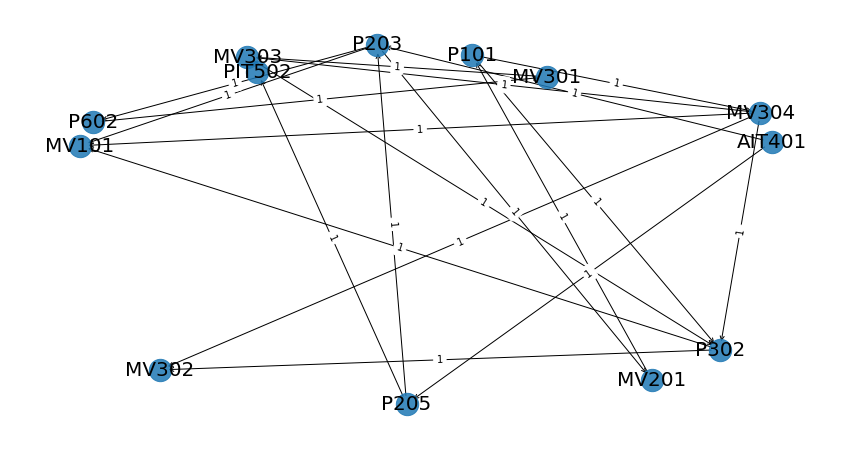

{'pos': {'LIT101': array([0.60276235, 0.86558448]),
  'MV101': array([-0.86110628,  0.43915741]),
  'P101': array([0.116695  , 0.94238472]),
  'P102': array([-0.63300948, -0.67937965]),
  'AIT201': array([-0.98060287, -0.03898706]),
  'AIT202': array([ 0.74493173, -0.4772567 ]),
  'AIT203': array([-0.9422203, -0.1679698]),
  'FIT201': array([-0.95121661, -0.34793108]),
  'MV201': array([ 0.56551263, -0.85716661]),
  'P201': array([-0.92203129,  0.19620107]),
  'P202': array([ 0.58787429, -0.74227446]),
  'P203': array([-0.11999408,  0.99883231]),
  'P204': array([ 0.97225811, -0.08979811]),
  'P205': array([-0.04607052, -0.99110859]),
  'P206': array([0.24278942, 0.97647119]),
  'DPIT301': array([ 0.25505167, -0.78005703]),
  'FIT301': array([-0.78503057, -0.61802225]),
  'LIT301': array([ 0.878895  , -0.59226379]),
  'MV301': array([0.30429845, 0.8207646 ]),
  'MV302': array([-0.6612921 , -0.80193659]),
  'MV303': array([-0.44332019,  0.93177865]),
  'MV304': array([0.83644535, 0.6219

In [11]:
bn.plot(model_learned)

## ADJACENCY MATRIX

In [13]:
vector = bn.adjmat2vec(model_learned['adjmat'])
A=(model_learned['adjmat'])
A = A.astype(int)
A.head(5)
A.head()


target,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,attack
source,,,,,,,,,,,,,,,,,,,,,
LIT101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MV101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AIT201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Normalization

In [74]:
def normalize_adj_numpy(adj, symmetric=True):
    if symmetric:
        d = np.diag(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0)
        a_norm = adj.dot(d).transpose().dot(d)
    else:
        d = np.diag(np.power(np.array(adj.sum(1)), -1).flatten(), 0)
        a_norm = d.dot(adj)
    return a_norm

In [75]:
a_norm = normalize_adj_numpy(A,symmetric=True)

In [76]:
edge_index = np.array(a_norm.values).T
edge_index

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan,  0., ...,  0., nan, nan],
       ...,
       [nan, nan,  0., ...,  0., nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [17]:
time_len,num_nodes  = train_df.shape
print("No. of sensors:", num_nodes, "\nNo. of timesteps:", time_len)

No. of sensors: 51 
No. of timesteps: 47340


In [77]:
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()
weights = torch.tensor([1]* edge_index.shape[1] , dtype=torch.double)
print(edge_index.shape)

torch.Size([51, 51])


## preprocess features

In [55]:
df = pd.concat([train_df,test_df])
print(df.shape)
df.attack.value_counts()

(92331, 51)


0    86838
1     5493
Name: attack, dtype: int64

In [57]:
node_features = df.drop(['attack'], axis=1).copy()
node_features.shape


(92331, 50)

## 1D Convolution

In [62]:
# Simple Conv
# Here we borrow method from sklearn
def conv(data):
    result = [] 
    for i in range(50):
        sample = data.iloc[:, i]
        sd = seasonal_decompose(sample, period=1000, extrapolate_trend='freq').trend
        result.append(sd)
    result = np.transpose(np.array(result), (1, 0))
    return result

In [63]:
node_features= conv(node_features)


In [64]:
node_features = torch.tensor(np.array(node_features, dtype=np.double), dtype=torch.double)

In [65]:
node_features.shape

torch.Size([92331, 50])

In [66]:
labels =df['attack'].values

In [69]:
from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, NNConv, DeepGCNLayer, GATConv, DenseGCNConv, GCNConv, GraphConv
from torch_geometric.data import Data, DataLoader

OSError: [WinError 127] The specified procedure could not be found

In [26]:
# converting data to PyGeometric graph data format
data_train = Data(x=node_features, edge_index=edge_index, edge_attr=weights,
                               y=torch.tensor(labels, dtype=torch.double)) #, adj= torch.from_numpy(np.array(adj))

NameError: name 'Data' is not defined